# Assignment 4: Random Forests  - Oscar Hernandez 

## Purpose

Our client -- Happy Real Estate Brokers -- wants to utilize machine learning models to complement their traditional valuation methods. Their goal is to assess the market value of residential real estate. This report will serve as an overview of the entire process (e.g. exploratory data analysis, model validation, etc.) taken to fulfill our client's needs. We will conclude the report with a final recommendation describing which machine learning model we believe will best allow them to assess the market value of residential real estate. Additionally, we will look to incorporate more advanced models to this analysis. 

#### This report will be broken up into Sections that cover the specific methodology that went into arriving at the final recommendation. The report will include and/or cover, at minimum, the following specific items and/or tasks:
* Utilize the Boston Housing Study data to train each machine learning algorithm
* Use all the explanatory variables in the data except "neighborhood" and use all 506 tract observations 
* The response variable will be the median value of homes in thousands of 1970s dollars
* Develop at least three regression methods - at least two: linear, ridge, lasso elastic net 
* and at least one random forest 
* Use K-fold cross-validation to calculate root mean-squared error scores to evaluate models
* Provide final management recommendation 


### Section 1 - Exploratory Data Analysis 

#### The first step in building a machine learning model is to gain a firm understanding of the data that will be used to train the model. Section 1 covers all the work that was completed as part of the Exploratory Data Analysis (EDA) process along with comments explaining code and output wherever necessary. 

In [1]:
#Load all the necessary packages we need to complete the exercise

import pandas as pd
import numpy as np
import matplotlib as plt
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import nbconvert
from sklearn.ensemble import RandomForestRegressor

In [3]:
#Read in Boston Housing Study data 
boston_input = pd.read_csv("boston.csv")

In [4]:
#Drop neighborhood attribute since it will not be used to make predictions  
boston_input = boston_input.drop("neighborhood", 1)

In [5]:
#This method allows us to further understand the type of data each of our 
#attributes holds and to see if there are missing values
boston_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rooms      506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
lstat      506 non-null float64
mv         506 non-null float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


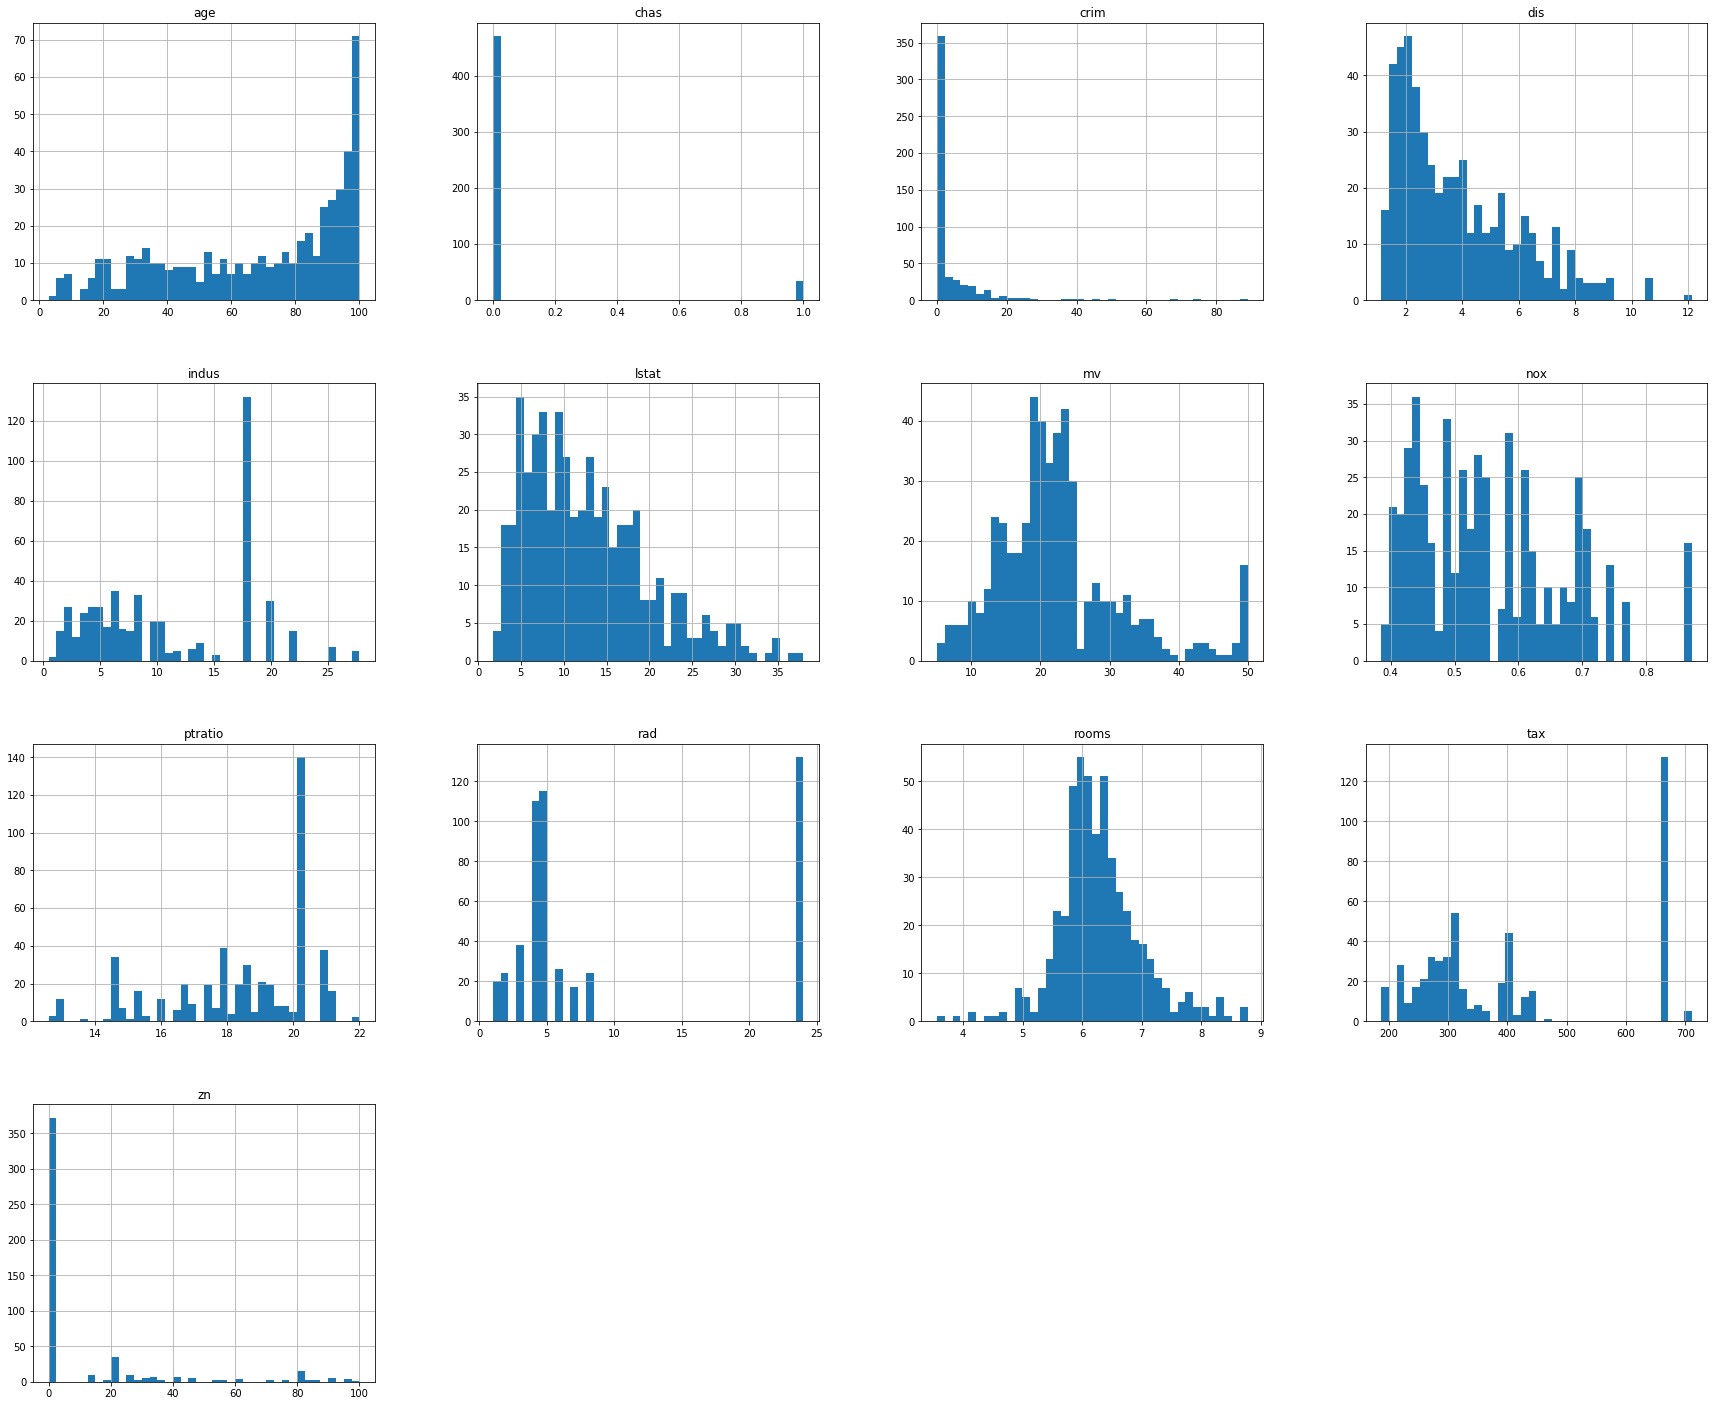

In [6]:
#Lets plot the distribution of all the attributes
#This provides us with visual insight of our attributes
%matplotlib inline
boston_input.hist(bins = 40, figsize=(30,25));

In [7]:
#Create correlation matrix to see the linear correlation between all the attributes 
#and the target variable - mv 
corr_matrix = boston_input.corr()
corr_matrix["mv"].sort_values(ascending=False)

mv         1.000000
rooms      0.696304
zn         0.360386
dis        0.249315
chas       0.175663
age       -0.377999
rad       -0.384766
crim      -0.389582
nox       -0.429300
tax       -0.471979
indus     -0.484754
ptratio   -0.505655
lstat     -0.740836
Name: mv, dtype: float64

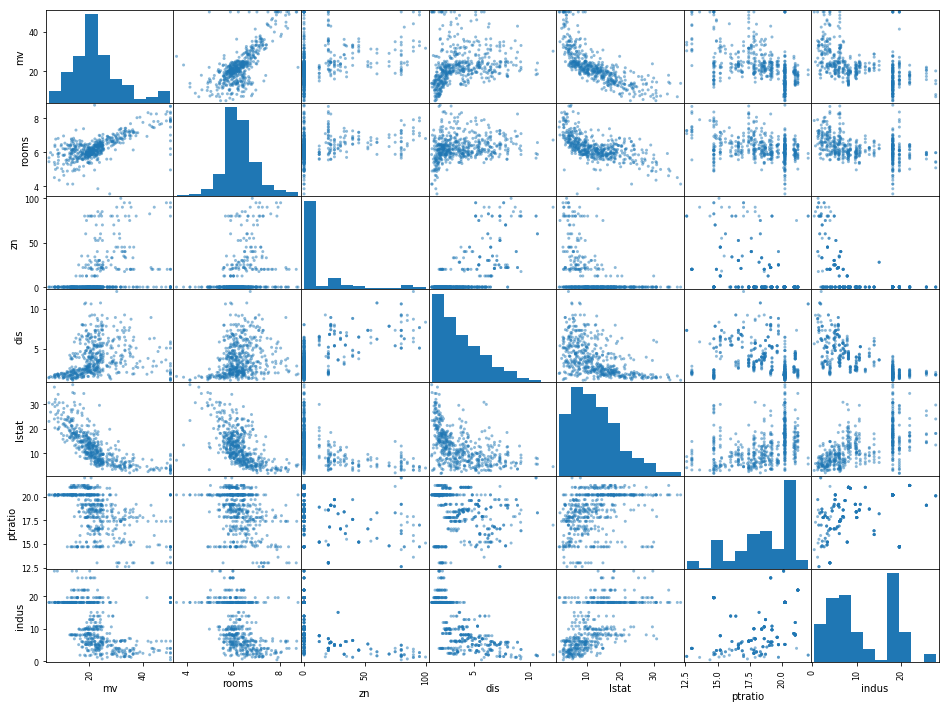

In [8]:
#Scatter plot matrix for select attributes was created to visualize correlation
attributes = ["mv","rooms", "zn", "dis", "lstat", "ptratio", "indus"]
scatter_matrix(boston_input[attributes], figsize=(16,12));

###### Key Takeaways (nonexhaustive)
* Based on correlation matrix, it looks like the rooms and lstat features have the highest linear correlation with the label - mv; this is further validated by looking at the scatterplot matrix 
* There seems to be more negatively correlated features with mv than positively correlated ones 
* mv appears to follow a normal distribution and most of the homes seem to have a median value between 20,000 - 25,000 (USD)
* Data set does not have any missing values although it does appear there was a cap placed on the mv variable
* Majority of homes are not by the Charles River (chas is the only dummy variable in the data set) 
* Appears as though feature scaling might be appropriate given the different scales 

### Section 2 - Data Preparation 

#### Upon completing the initial EDA process, we got a better understanding of the features that make up the data set. The next section in this exercise is to prepare the data that will be used to train the machine learning algorithms.  Typically, this step involves imputing missing values, determining how to deal with outliers, and fixing any erroneous values. Also, variable transformation and feature scaling must be considered as well during this step. 

In [9]:
#Make a copy of the original data set
boston = boston_input.copy()

In [10]:
#Utilize function to split the data set into a training set and test set
#The parameters in the section dictate the size of the test set and a random 
#generator seed so that the data is split using the same shuffled indices
train_set, test_set = train_test_split(boston, test_size = 0.2, random_state = 10)

In [11]:
#At this point, several decisions need to be made in terms of transformations
#Since there are no missing values, we will not need to address that aspect
#Split the labels away from the training set
boston_train = train_set.drop("mv", axis =1)
boston_train_labels = train_set["mv"].copy()

In [138]:
#We will not make any transformations to the data set 
#This will not impact the random forest model 

##### Key Takeaways
* This section focused on splitting the Boston data set into training and testing subsets. We decided to allocate 20% of the Boston data set to be used as the test data set


### Section 3 - Build Models

#### Now we will build multiple machine learning models based on the updated training data. We will continue to utilize Scikit-Learn in this section. Specifically, we will utilize different algorithms to train our models.Since this is a supervised learning exercise, we will have the labels separated as well. 

#### Each algorithm arrives at the y-intercept and coefficients differently. For example, the Ridge regression tries to keep the weights as small as possible while the Lasso regression (another regularized version of linear regression) tries to completely eliminate the weights of the least important features. Random forest models work well on large data sets and don't require predictor variables to be transformed. 

In [12]:
#Build Linear Regression Model using SVD
#Print out the y-intercept and coefficients 
lin_reg = LinearRegression()
lin_reg.fit(boston_train, boston_train_labels)
lin_reg.intercept_, lin_reg.coef_

(43.434332443307099,
 array([ -1.40268033e-01,   6.54420255e-02,  -2.21943528e-02,
          2.23448629e+00,  -1.79103492e+01,   2.84688219e+00,
          2.03980094e-02,  -1.53491580e+00,   2.75519071e-01,
         -1.25966769e-02,  -7.82169515e-01,  -6.14153534e-01]))

In [13]:
#Build Lasso Regression Model 
#Print out the y-intercept and coefficients 
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(boston_train, boston_train_labels)
lasso_reg.intercept_, lasso_reg.coef_

(32.309568587159163,
 array([-0.13385732,  0.0680292 , -0.07795741,  0.44280691, -0.        ,
         2.76277635,  0.00834207, -1.22241473,  0.23946216, -0.01464598,
        -0.57460214, -0.6620217 ]))

In [19]:
#Build Random Forest Regression Model with three trees
forest_reg1 = RandomForestRegressor(n_estimators=3, random_state = 1)
forest_reg1.fit(boston_train, boston_train_labels)
forest_reg1;

In [20]:
#Build Random Forest Regression Model with six trees
forest_reg2 = RandomForestRegressor(n_estimators=6, random_state = 5)
forest_reg2.fit(boston_train, boston_train_labels)
forest_reg2;

##### Key Takeaways
* This section was straight-forward in the sense that Scikit-Learn was utilized to create all the models
* From purely "eyeballing" the intercept and coefficients of the linear models, we notice that they are all similar; Note: that reviewing the p-values and model statistical signficance is not of high importance to us during this exercise since our main goal is predictive accuracy 
* Looking at the y-intercepts of the linear regression models, we can see a pretty big difference
* There are more negative coeffecients (in linear models) which makes sense given the correlation matrix that was outputted during the EDA section
* At this step, we simply trained various models but have not decided which one yet is our "best" one 

### Section 4 - Model Validation

#### This section will cover the cross-validation steps utilized to measure the performance of each model. Evaluating each model based on an objective criteria is necessary to understand how well each model can generalize (i.e. overfitting/underfitting) new data. Predictive accuracy is of upmost importance because our client will be utilizing our recommendation to assess the market value of residential real estate. 

In [21]:
#Use each model to make predictions 
linreg_predictions = lin_reg.predict(boston_train)

lasso_predictions = lasso_reg.predict(boston_train)
forest1_predictions = forest_reg1.predict(boston_train)
forest2_predictions = forest_reg2.predict(boston_train)

In [22]:
#Print out the Root Mean Square Error for each model's predictions
linreg_mse = mean_squared_error(boston_train_labels, linreg_predictions)
lasso_mse = mean_squared_error(boston_train_labels, lasso_predictions)

forest1_mse = mean_squared_error(boston_train_labels, forest1_predictions)
forest2_mse = mean_squared_error(boston_train_labels, forest2_predictions)

linreg_rmse = np.sqrt(linreg_mse)
print("linreg_rmse:", linreg_rmse,"\n")

lasso_rmse = np.sqrt(lasso_mse)
print("lasso_rmse:", lasso_rmse, "\n")

forest1_rmse = np.sqrt(forest1_mse)
print("forest1_rmse:", forest1_rmse, "\n")
forest2_rmse = np.sqrt(forest2_mse)
print("forest2_rmse:", forest2_rmse, "\n")


linreg_rmse: 4.45177181036 

lasso_rmse: 4.5854548831 

forest1_rmse: 1.97855040779 

forest2_rmse: 1.51088164289 



In [23]:
#Utilize K-fold cross-validation to calculate RMSE scores
linreg_scores = cross_val_score(lin_reg, boston_train, boston_train_labels, 
                                scoring="neg_mean_squared_error", cv=4)

lasso_scores = cross_val_score(lasso_reg, boston_train, boston_train_labels, 
                               scoring="neg_mean_squared_error", cv=4)
forest1_scores = cross_val_score(forest_reg1, boston_train, boston_train_labels, 
                               scoring="neg_mean_squared_error", cv=4)
forest2_scores = cross_val_score(forest_reg2, boston_train, boston_train_labels, 
                               scoring="neg_mean_squared_error", cv=4)
linreg_rmse_scores = np.sqrt(-linreg_scores)
lasso_rmse_scores = np.sqrt(-lasso_scores)
forest1_rmse_scores = np.sqrt(-forest1_scores)
forest2_rmse_scores = np.sqrt(-forest2_scores)

In [24]:
#Create function to display the RMSE score statistics for each model 
def display_scores(scores):
    print ("Scores:", scores)
    print ("Mean:", scores.mean())
    print ("Standard Deviation:", scores.std())

In [25]:
#Use function to print out descriptive info about the results of the K-fold 
#cross-validation for each model
print("Linear Regression w/ SVD RMSE")
display_scores(linreg_rmse_scores)
print("\n")

print("Lasso Regression RMSE")
display_scores(lasso_rmse_scores)
print("\n")

print("Random Forest 1 RMSE")
display_scores(forest1_rmse_scores)
print("\n")

print("Random Forest 2 RMSE")
display_scores(forest2_rmse_scores)
print("\n")

Linear Regression w/ SVD RMSE
Scores: [ 4.62962147  4.55924433  4.31124612  5.01131623]
Mean: 4.62785703803
Standard Deviation: 0.250995140913


Lasso Regression RMSE
Scores: [ 4.69238663  4.5377426   4.51413872  5.25899771]
Mean: 4.75081641675
Standard Deviation: 0.301280206054


Random Forest 1 RMSE
Scores: [ 3.36422648  3.90265206  3.76275974  5.4841897 ]
Mean: 4.12845699217
Standard Deviation: 0.807276562952


Random Forest 2 RMSE
Scores: [ 3.58691547  3.47164691  3.45599438  5.69807665]
Mean: 4.05315835204
Standard Deviation: 0.951038776829




In [26]:
#Evaluate two of our best models on the test set - both RF models  
#Split the test set into just the features and label
boston_test = test_set.drop("mv", axis =1)
boston_test_labels = test_set["mv"].copy()

In [27]:
#Save the model parameters from the two best trained models 
forest1_model = forest_reg1.fit(boston_train, boston_train_labels)
forest2_model = forest_reg2.fit(boston_train, boston_train_labels)

In [28]:
#Make final predictions using each model
forest1_final_predictions = forest1_model.predict(boston_test)
forest2_final_predictions = forest2_model.predict(boston_test)

In [30]:
#Compare RMSE scores
forest1_final_mse = mean_squared_error(boston_test_labels, forest1_final_predictions)
forest1_final_rmse = np.sqrt(forest1_final_mse)
print("forest1_final_rmse:", forest1_final_rmse, "\n")
forest2_final_mse = mean_squared_error(boston_test_labels, forest2_final_predictions)
forest2_final_rmse = np.sqrt(forest2_final_mse)
print("forest2_final_rmse:", forest2_final_rmse, "\n")

forest1_final_rmse: 4.44051460246 

forest2_final_rmse: 3.66545880284 



In [43]:
#We need to rank the best features of the model 
importances = forest_reg2.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_reg2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(boston_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 11 (0.430806)
2. feature 5 (0.382468)
3. feature 7 (0.083682)
4. feature 0 (0.037217)
5. feature 10 (0.018121)
6. feature 6 (0.014784)
7. feature 4 (0.014491)
8. feature 9 (0.011313)
9. feature 2 (0.004308)
10. feature 8 (0.001674)
11. feature 1 (0.000663)
12. feature 3 (0.000472)


##### Key Takeaways
* We first determined the RMSE scores using the models on the training data set. The RMSE scores for the random forests models were noticeably lower compared to the linear regression models. The random forest model that built more trees due to the n_estimators parameter being higher, had the lowest RMSE score. 

* During the cross-validation step, we noticed that the second random forest model that was built also had the lowest average RMSE score compared to the other models. However, it had the largest standard deviation for the RMSE scores that were calculated as part of the k-fold cross-validation. The Linear Regression w/ SVD had the lowest standard deviation. 

* There is some evidence that the random forest models did overfit because the RMSE score on the training set is lower than the average RMSE score from the k-fold cross-validation. 

* Since both the random forest models performed the best on the training data, we decided to deploy them on the test data set. 

* The second random forest model (w/ higher trees) had the lower RMSE score. As expected, both RMSE scores were higher then the RMSE scores on the training data set. Interestingly, the RMSE score for the second random forest model was lower than the average RMSE score from the k-fold cross-validation. 

### Section 5 - Final Recommendation

In summary, we recommend that Happy Real Estate Brokers utilize the second Random Forest Regression Model that we developed. This model performed the best on the training data with regards to the RMSE score. Furthermore, upon using k-fold cross-validation, it had the lowest average RMSE score which provided more evidence of its performance. Lastly, when compared with the other best model, the second Random Forest Regression Model had a much lower RMSE score on the test data. Given that predictive accuracy is the key focus of this task and is what will help the client the most, it makes sense to choose the model that scored the best on the RMSE metric. 

Also, after looking at the feature ranking, we can state that the rooms and lstat predictor variables are the most important in predicting home prices. They have the highest importance -- 0.43 and 0.38, respectively. 